In [1]:
!pip install mediapipe

     |████████████████████████████████| 37.7MB 85kB/s 


In [2]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# importamos la pipeline necesaria
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Deteccion de puntos faciales "simple"

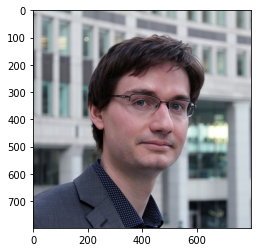

In [5]:
# primero probamos una deteccion simple
# cargamos la imagen y la
face = cv2.imread('/content/drive/MyDrive/EDEM_Master/PosesFaces/chollet.jpg')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.imshow(face)
plt.show()

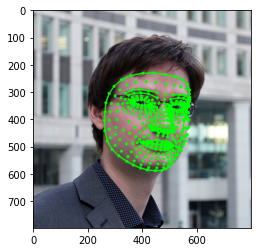

In [6]:
# damos parametros para la deteccion facial y para su anotacion
drawing_spec = mp_drawing.DrawingSpec(thickness=4, circle_radius=3)
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# le damos la imagen para que la procese
results = face_mesh.process(face)

# creamos una copia para poder dibujar encima
canvas = face.copy()

# iteramos por las caras detectadas y dibujamos los resultados
for face_landmarks in results.multi_face_landmarks:
  mp_drawing.draw_landmarks(
          image=canvas,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACE_CONNECTIONS,
          landmark_drawing_spec=drawing_spec,
          connection_drawing_spec=drawing_spec)
plt.imshow(canvas)
plt.show()

## Representacion 3D

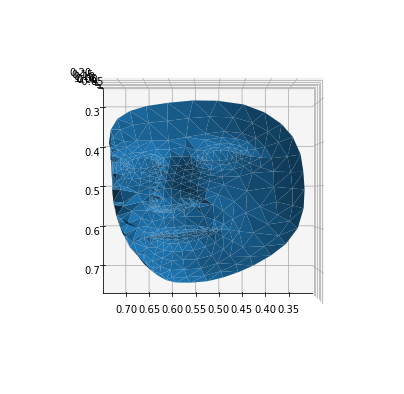

In [7]:
# metemos las coordenadas iterando a mano en buffers
x = []
y = []
z = []
points = results.multi_face_landmarks[0]
for landmark in points.landmark:
  x.append(landmark.x)
  y.append(landmark.y)
  z.append(landmark.z)

# creamos la representacion 3d usado una representacion triangulada
ax = plt.figure(figsize=(7, 7)).add_subplot(projection='3d')
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
ax.view_init(90, 90)
plt.show()

# probamos con:
# face = cv2.imread('/content/drive/MyDrive/EDEM_Master/PosesFaces/surprised.jpg')

# A donde miras?

In [8]:
# vamos a sacar a partir de los puntos, a que direccion se esta mirando
# usamos un modelo de cara mirando al frente como referencia
front_model = np.load('/content/drive/MyDrive/EDEM_Master/PosesFaces/front_model.npy')
print(front_model.shape)
print(front_model.T.shape)

(468, 3)
(3, 468)


In [9]:
# juntamos las coordenadas nuestras
x = np.expand_dims(np.array(x), axis=-1)
y = np.expand_dims(np.array(y), axis=-1)
z = np.expand_dims(np.array(z), axis=-1)
print(x.shape, y.shape, z.shape)
actual_face_coords = np.concatenate([x, y, z], axis=-1)
print(actual_face_coords.shape)

(468, 1) (468, 1) (468, 1)
(468, 3)


In [ ]:
# funcion de calculo de la matrix de rotacion y vector de translacion
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [ ]:
# calculamos con nuestros puntos
R, t = rigid_transform_3D(front_model.T, actual_face_coords.T)
print(R)

In [ ]:
# creamos la matriz de cambio de perspectiva
pose_mat = cv2.hconcat((R, t))
# hacemos su descomposicion
_, _, _, _, _, _, euler_angle = cv2.decomposeProjectionMatrix(pose_mat)
euler_angle

# euler_angle es un vector tridimensional que indica la rotacion en angulos del eje x, y, z respectivamente
# en geometria tridimensional:
# x -> pitch
# y -> yaw
# z -> roll